# Knapsack problem

The knapsack problem is a combinatorial optimization problem that seeks to find the best set of objects to fit into a knapsack while obeying a weight constraint. Mathematically, it can be expressed as:

$$
\begin{aligned}
&\text{maximize} & & v^T x \\
&\text{subject to} & & w^T x \leq \theta \\
& & & x_i \in \{0,1\} \\
\end{aligned}
$$

where $v \in \mathbb{R}^n_+$, $w \in \mathbb{R}^n_+$, and $\theta \in \mathbb{R}_+$.

This notebook utilizes a genetic algorithm to solve the problem.


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import itertools

# Build class that implements genetic algorithm


In [2]:
class Knapsack():
    '''
    Class that solves the knapsack problem 
    with a genetic algorithm
    '''
    
    def __init__(self, values, weights, threshold):
        '''
        Arguments
        ---------
        values : np.array
            Vector of items values
        weights : np.array
            Vector of item weights
        threshold : float
            The maximum allowable weight inside knapsack
        '''
        self.values = values
        self.weights = weights
        self.threshold = threshold
        self.n_items = len(values)
        
    
    def genesis(self, population_size):
        '''
        Creates the initial population of candidate
        solutions.
        
        Rather than flipping a coin to determine
        whether a given candidate solution will
        be initialized with an item, this function 
        instead randomly generates a probability 
        with which the candidate solution will 
        choose an item.
        
        Arguments
        ---------
        population_size : int
            How many individuals to include in the population
        '''
        expected_num_items = np.random.randint(1, self.n_items+1, population_size)
        p = expected_num_items/self.n_items
        p = np.tile(p, (self.n_items,1)).T
        U = np.random.uniform(size=(population_size,self.n_items))
        population = (U <= p).astype('int')
        return population

    
    def compute_fitness(self, candidate):
        '''
        Computes fitness score for a candidate solution
        
        Arguments
        ---------
        candidate : np.arry of shape (self.n_items,) or (population_size, self.n_items)
            Array that contains a candidate solution
            or multiple candidate solutions
        '''
        v = candidate.dot(self.values)
        w = candidate.dot(self.weights)
        fitness = v * (w <= self.threshold)
        return fitness
    
    
    def get_mating_pool(self, population, fitness, n_competition):
        '''
        Generate the set of candidate solutions that will
        be eligible to "mate" to create the next generation
        
        Arguments
        ---------
        population : np.array
            Array containing entire population of candidate solutions
        fitness : np.array
            Array containing the fitness score for each candidate solution
        n_competition : int
            The number of individuals that compete with one another
            when determining which gets to mate
        '''
        mating_pool = list()
        idx = np.random.permutation(range(len(population))).tolist()
        while len(idx) > 0:
            candidates = [idx.pop() for i in range(min(n_competition, len(idx)))]
            winner = candidates[np.argmax(fitness[candidates])]
            mating_pool.append(population[winner])
        return mating_pool
    
        
    def mate(self, parent_a, parent_b):
        '''
        Generate a child using two parents
        
        Arguments
        ---------
        parent_a : np.array
            The candidate solution for parent A
        parent_b : np.array
            The candidate solution for parent B
        '''
        mask_a = np.random.randint(0,2, self.n_items) # binary mask
        mask_b = 1 - mask_a
        child = mask_a*parent_a + mask_b*parent_b
        return child
    
    
    def mutate(self, child, prob):
        '''
        Randomly mutate a candidate solution
        
        Arguments
        ---------
        child : np.array
            The candidate solution to randomly mutate
        prob : float in range [0,1]
            The mutation probability
        '''
        U = np.random.uniform(size=self.n_items)
        mutate = (U < prob).astype('int')
        child_mutated = child + ((-1)**child)*mutate
        return child_mutated
    

    def breed_generation(self, mating_pool, n_offspring, fecundity, mutation_prob):
        '''
        Generate the next generation of candidation solutions
        
        Arguments
        ---------
        mating_pool : list[np.array]
            The list of candidate solutions that will
            mate to produce the next generation
        n_offspring : int
            The total number of offspring that need
            to be produced
        fecundity : int
            The number of children produced by each pair of mates
        '''
        offspring = list()
        while len(offspring) < n_offspring:
            idx_a, idx_b = np.random.choice(np.arange(len(mating_pool)), size=2, replace=False)
            parent_a = mating_pool[idx_a]
            parent_b = mating_pool[idx_b]

            n_children = min(fecundity, n_offspring-len(offspring))
            for j in range(n_children):
                child = self.mate(parent_a, parent_b)
                child = self.mutate(child, mutation_prob)
                offspring.append(child)
                
        return offspring
    
    
    def evolve(self, population, elitism, n_competition, mutation_prob):
        '''
        Perform one generation of evolution
        
        Arguments
        ---------
        population : np.array
            Array of candidate solutions.
            Row i contains candidate solution i.
            Entry j of row i is 1 if candidate
            solution i selects item j, 0 otherwise.
        elitism : int
            How many of the best solutions to automatically
            carry forward into the next generation
        '''
        offspring = list()
        fitness = self.compute_fitness(population)
        
        # Enforce elitism
        elite = np.argsort(fitness)[-elitism:]
        offspring.extend([population[x] for x in elite])

        # Breed new generation
        mating_pool = self.get_mating_pool(population, fitness, n_competition)
        n_offspring = len(population) - len(offspring)
        children = self.breed_generation(mating_pool, n_offspring, 2*n_competition, mutation_prob)
        offspring.extend(children)
        
        return np.array(offspring)
    
    
    def solve(self, 
              max_generations, 
              population_size, 
              elitism, 
              n_competition, 
              mutation_prob,
              patience):
        '''
        Solve the knapsack problem
        
        Arguments
        ---------
        population_size : int
            How many candidate solutions to use in each generation
        elitism : int
            How many of the best solutions to automatically
            carry forward into the next generation
        n_competition : int
            The number of individuals that compete with one another
            when determining which ones gets to mate
        mutation_prob : float
            The mutation probability, i.e. the probability
            that the decision to include/exclude any given
            item will be reversed.
        patience : int
            How many generations of zero improvement to
            wait before terminating algorithm
        max_generations : int
            Maximum number of generations of evolution to perform
        '''
        start = time.time()
        population = self.genesis(population_size)
        self.solution = [population]
        self.solution_value = [self.compute_fitness(population).max() + 1e-5] # avoid zero division
        counter = 0
        
        for i in range(max_generations):
            fitness = self.compute_fitness(population)
            offspring = self.evolve(population, elitism, n_competition, mutation_prob)
            population = offspring
            
            idx_alpha = np.argmax(fitness)
            alpha = population[idx_alpha]
            alpha_value = fitness[idx_alpha]
            self.solution.append(alpha)
            self.solution_value.append(alpha_value)
            
            improvement = (self.solution_value[-1] - self.solution_value[-2]) / self.solution_value[-2]
            if improvement > 0:
                counter = 0
            else:
                counter += 1
            if counter > patience:
                break
                
        speed = time.time() - start

        return alpha, alpha_value, speed
            

# Test algorithm

In [3]:
n_items = 500

# Generate random problem data
values = np.random.randint(1, 100, n_items)
weights = np.random.randint(1, 100, n_items)
threshold = np.random.choice(weights, size=int(n_items/2)).sum()

k = Knapsack(values, weights, threshold)

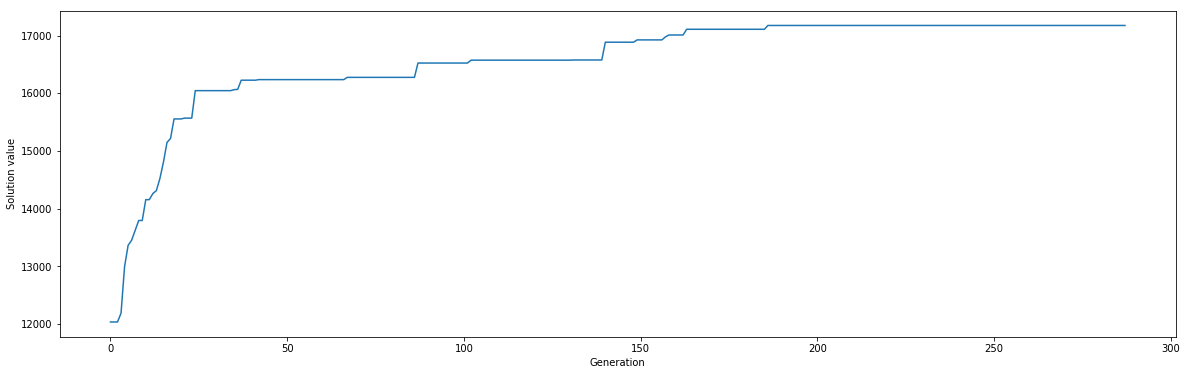

In [5]:
alpha, alpha_value, speed = k.solve(population_size=50, 
                                    elitism=5, 
                                    n_competition=4, 
                                    mutation_prob=0.05,
                                    patience=100,
                                    max_generations=3000)

plt.figure(figsize=(20,6))
plt.plot(k.solution_value)
plt.xlabel('Generation')
plt.ylabel('Solution value')
plt.show()


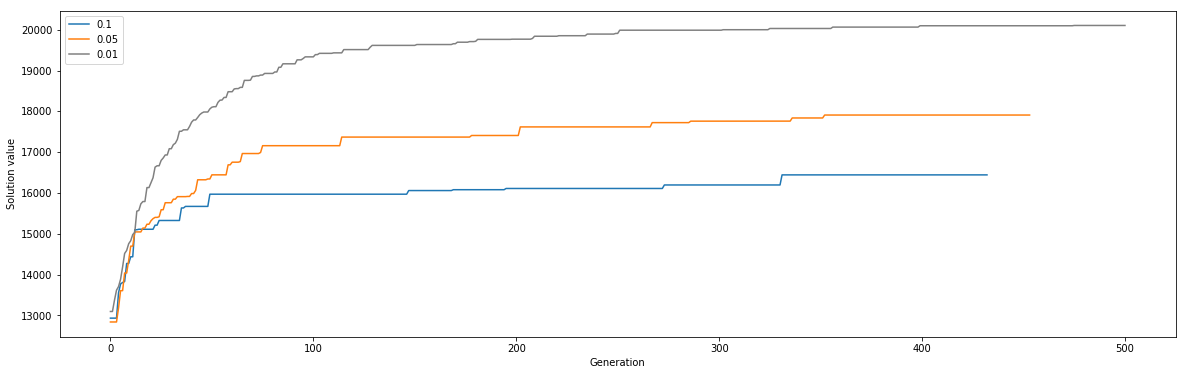

In [6]:
m = 500

plt.figure(figsize=(20,6))

k.solve(population_size=100, elitism=10, n_competition=4, mutation_prob=0.1, patience=100, max_generations=m)
plt.plot(k.solution_value, label=0.1)

k.solve(population_size=100, elitism=10, n_competition=4, mutation_prob=0.05, patience=100, max_generations=m)
plt.plot(k.solution_value, label=0.05)

k.solve(population_size=100, elitism=10, n_competition=4, mutation_prob=0.01, patience=100, max_generations=m)
plt.plot(k.solution_value, label=0.01, c='gray')

plt.xlabel('Generation')
plt.ylabel('Solution value')
plt.legend()
plt.show()


# Analyze algorithm performance

There are two important factors to consider when analyzing an approximate solution:
1. How close the approximate solution gets to the true solution
2. How quickly the approximate algorithm can compute a solutions

To answer assess these factors for the genetic algorithm, I solve below the knapsack problem using the brute force algorithm for several different problem sizes, i.e. different numbers of items to consider putting inside the knapsack. For each problem size, I compute:
1. The ratio of the solution generated by the genetic algorithm to the brute force solution
2. The ratio of the execution time of the genetic algorithm to that of the brute force solution


In [7]:
def get_random_problem_data(problem_size):
    values = np.random.randint(1, 100, problem_size)
    weights = np.random.randint(1, 100, problem_size)
    threshold = np.random.choice(weights, size=int(problem_size/2)).sum()
    return values, weights, threshold


In [8]:
def brute_force_algo(values, weights, threshold):
    start = time.time()
    choices = [[0,1] for i in range(len(values))]
    best_solution = None
    best_solution_value = -np.inf
    
    for candidate in itertools.product(*choices):
        x = np.array(candidate)    
        v = x.dot(values) * (x.dot(weights) <= threshold)
        if v > best_solution_value:
            best_solution = x
            best_solution_value = v
            
    speed = time.time() - start    
    return best_solution, best_solution_value, speed


In [9]:
ratio_speed = list()
ratio_optimality = list()

problem_size = np.arange(6,22+1)
for n in problem_size:
    values, weights, threshold = get_random_problem_data(n)
    
    # Genetic algorithm
    genetic_algo = Knapsack(values, weights, threshold)
    solution_genetic, \
        value_genetic, \
        speed_genetic = genetic_algo.solve(population_size=100, 
                                          elitism=10,
                                          n_competition=4, 
                                          mutation_prob=0.05,
                                          patience=200,
                                          max_generations=1000)
    
    # Brute force algorithm
    solution_brute_force, \
        value_brute_force, \
        speed_brute_force = brute_force_algo(values, weights, threshold)
    
    ratio_speed.append(speed_genetic / speed_brute_force)
    ratio_optimality.append(value_genetic / value_brute_force)
    

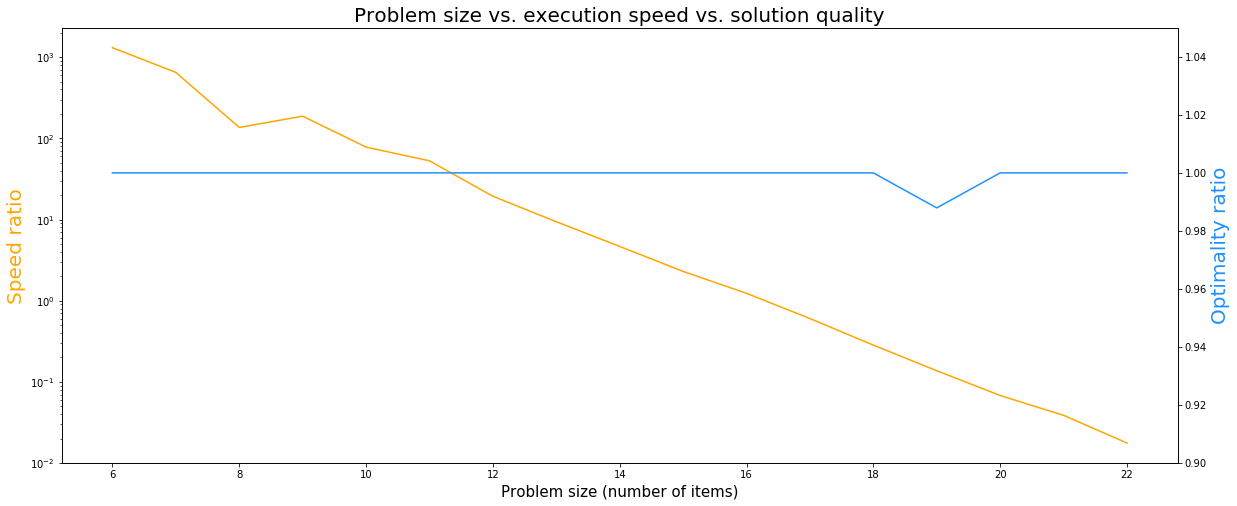

In [10]:
x = problem_size
y1 = ratio_speed
y2 = ratio_optimality

fig, ax1 = plt.subplots(figsize=(20,8))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'orange')
ax2.plot(x, y2, 'dodgerblue')
ax1.set_xlabel('Problem size (number of items)', fontsize=15)
ax1.set_ylabel('Speed ratio', color='orange', fontsize=20)
ax2.set_ylabel('Optimality ratio', color='dodgerblue', fontsize=20)
ax2.set_ylim([0.9, 1.05])
ax1.set_yscale('log')
plt.title('Problem size vs. execution speed vs. solution quality', fontsize=20)
plt.show()
